In [9]:
# Feature learning on metric point clouds for segmentation and classification
Even though 3D sensing of the environment with low-cost sensors is commonplace, very few DL approaches actively exploit the inherent benefits of having a metric spatial imaging of the object you try to classify. Intuitively - DNNs used for object classification using 2D data would have to spend capacity learning slightly different poses of objects where a point cloud based network could more efficiently encode the features by being pose invariant.  

![Pointnet teaser](http://stanford.edu/~rqi/pointnet/images/teaser.jpg)

One such network is [PointNet++](https://stanford.edu/~rqi/pointnet2/) The general idea of PointNet++ is simple. We first partition the set of points into overlapping local regions by the distance metric of the underlying space. Similar to CNNs, we extract local features capturing fine geometric structures from small neighborhoods; such local features are further grouped into larger units and processed to produce higher level features. This process is repeated until we obtain the features of the whole point set.

![Overall structure of PointNet. Note the reuse for early layers for different end tasks](https://stanford.edu/~rqi/pointnet2/images/pnpp.jpg)  

As is quite obvious from the illustrated network structure, segmentation is very similar to an encode-decode bottleneck, and classification by using similar encoding and a fully connected stack. 

In this network the direct analog to a convolutional layer is the PointNet. This is quite simply a stack containing an input align network that feeds point data into a stack of MLPs that are max-pooled and fed into a feature aligner. The output from this feature alignment is (hopefully!) a canonical feature representation of the input. This architecture can be trained with classical back propagation.

For further reference, consult the paper or [slide deck](http://stanford.edu/~rqi/pointnet/docs/cvpr17_pointnet_slides.pdf) from Qi et al from CVPR 2017. These slides do a very good job of explaining the network as well as demonstrating that the PointNet learns non-trivial features of the point clouds.  

One interesting detail with PointNet is the relatively low cost for inference compared to extending a regular convnet to an extra dimension, since the representation is fairly efficient in the number of weights (which grows geometrically with dimension) 

The experiments in this lab will be on pre-trained models due to the computational cost of training.

- **Classification pipeline**: Run through a couple of examples from the ModelNet database and observe performance. Try different hierarchical groupings, single scale and multi scale. Can you observe any improvement? 
- **Parts segmentation pipeline**: In principle there are two strategies for encoding 
- **Preprocess and classify own captured point cloud data**: Consider 
- **For extra credit: See how much you can transform the point clouds before classifier breaks down**
- **For extra credit: Experiment with scripts for training classification and segmentation**

The original code has been adapted to a notebook format, and this can cause some confusion. When changing parameters some cells containing only defs may need to be rerun.  

SyntaxError: invalid syntax (<ipython-input-9-2a1bed1149d7>, line 2)

## Prerequisites

In [10]:
#Prerequisites. The network is implemented Tensorflow and some of the visualization will be in visdom due to its 3D nature. 
from __future__ import absolute_import,print_function, division
#from visdom import Visdom
from ipywidgets import FloatProgress
from IPython.display import display
import numpy as np
import math
import sys
import os.path
import getpass
import importlib
from datetime import datetime
from sys import platform as _platform
import tensorflow as tf
LAB_DIR = os.path.dirname(os.path.abspath('Lab4.ipynb')) 
ROOT_DIR = os.path.join(LAB_DIR,'pointnet2')
sys.path.append(os.path.join(ROOT_DIR,'classification'))
sys.path.append(os.path.join(ROOT_DIR,'part_seg'))
sys.path.append(os.path.join(ROOT_DIR, 'models'))
sys.path.append(os.path.join(ROOT_DIR, 'utils'))
import provider
import modelnet_dataset
GPU_INDEX = 0 #Need tuning for multiuser case

#


def mode(ndarray, axis=0):
    modals, counts = np.unique(ndarray, return_counts=True)
    index = np.argmax(counts)
    return modals[index] #, counts[index]




ModuleNotFoundError: No module named 'provider'

## Example of classification on [Modelnet](http://modelnet.cs.princeton.edu) data
ModelNet is a large set of CAD-models of everyday objects, and this exercise will use a 40-class aligned subset of these. 

In [4]:
#Parameters shared for train and eval  
CLS_BATCH_SIZE = 32
CLS_NUM_POINT = 1024
CLS_LOG_DIR = os.path.join(ROOT_DIR,'classification/log/')
CLS_CKPT_NAME = 'model.ckpt' #Change to avoid overwriting if training 
CLS_MODEL_PATH = os.path.join(CLS_LOG_DIR,CLS_CKPT_NAME) 
CLS_MODELNAME = 'pointnet2_cls_ssg'
CLS_MODEL = importlib.import_module(CLS_MODELNAME) # import network module - look in models folder for others
CLS_NUM_CLASSES = 40
CLS_USENORMAL = False
CLS_SHAPE_NAMES = [line.rstrip() for line in \
    open(os.path.join(ROOT_DIR, 'data/modelnet40_ply_hdf5_2048/shape_names.txt'))]

# ModelNet official train/test split
CLS_DATA_PATH = os.path.join(ROOT_DIR, 'data/modelnet40_normal_resampled')
CLS_TRAIN_DATASET = modelnet_dataset.ModelNetDataset(root=CLS_DATA_PATH, npoints=CLS_NUM_POINT, split='train', normal_channel=CLS_USENORMAL)
CLS_TEST_DATASET = modelnet_dataset.ModelNetDataset(root=CLS_DATA_PATH, npoints=CLS_NUM_POINT, split='test', normal_channel=CLS_USENORMAL)



NameError: name 'os' is not defined

### Familiarize yourself with the data
Use something similar to the code below to visualize examples of the different classes in the dataset. 
Visdom should be running at the same instance at port 8097

{'desk': 12, 'table': 33, 'range_hood': 28, 'bed': 2, 'guitar': 17, 'wardrobe': 38, 'cup': 10, 'bench': 3, 'glass_box': 16, 'tent': 34, 'car': 7, 'sink': 29, 'bookshelf': 4, 'bowl': 6, 'plant': 26, 'keyboard': 18, 'xbox': 39, 'curtain': 11, 'stool': 32, 'person': 24, 'sofa': 30, 'laptop': 20, 'piano': 25, 'dresser': 14, 'mantel': 21, 'stairs': 31, 'monitor': 22, 'flower_pot': 15, 'chair': 8, 'airplane': 0, 'bottle': 5, 'vase': 37, 'toilet': 35, 'tv_stand': 36, 'night_stand': 23, 'lamp': 19, 'door': 13, 'cone': 9, 'bathtub': 1, 'radio': 27}


<IPython.core.display.Javascript object>


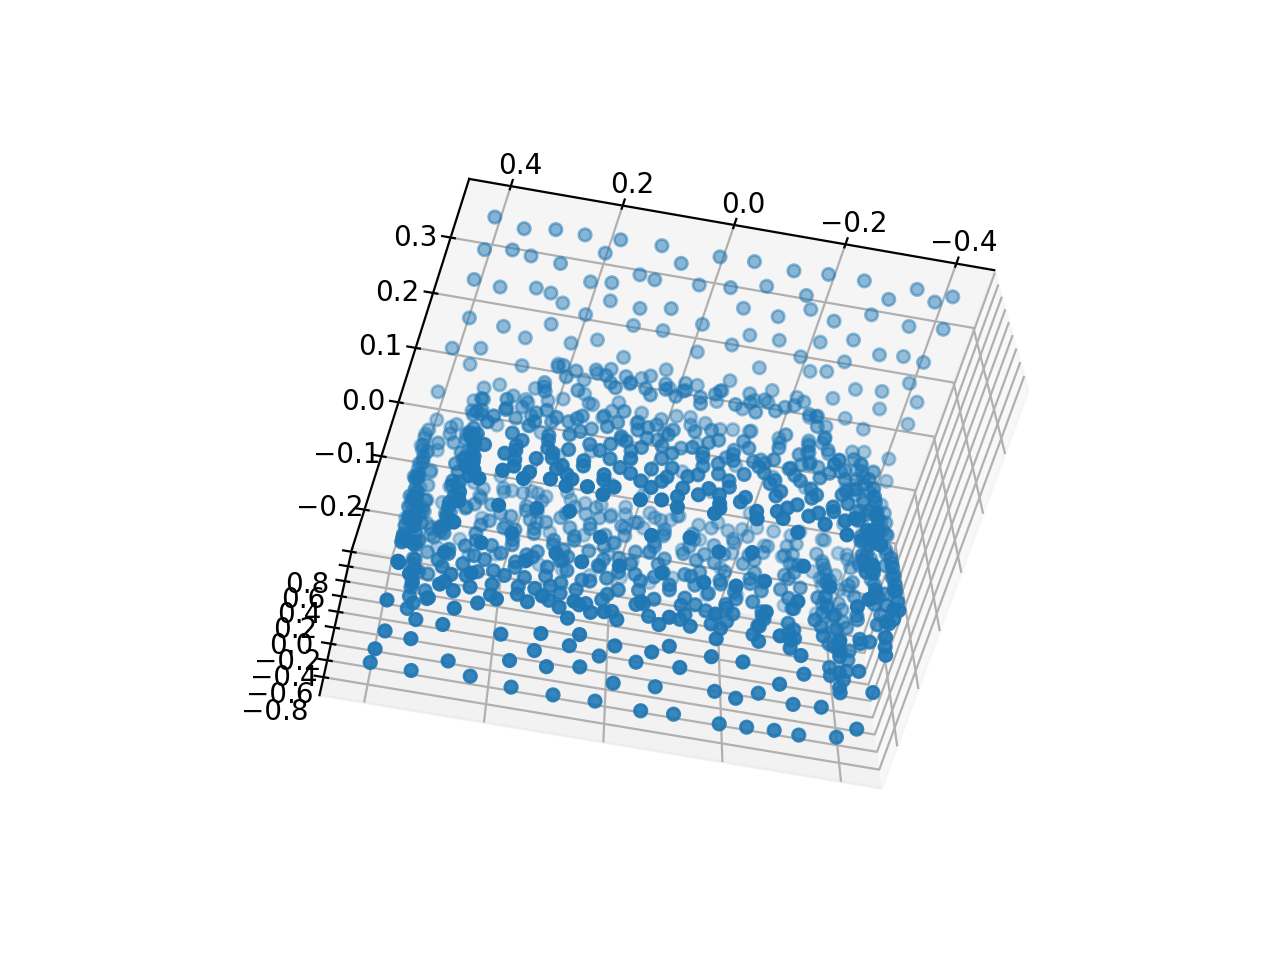

In [38]:
print(CLS_TEST_DATASET.classes)


def get_single_sample(dataset,idx):
    data,cls = dataset[idx]
    return data, [k for k, v in CLS_TRAIN_DATASET.classes.items() if v == cls]

pc, cat = get_single_sample(CLS_TEST_DATASET,230)

#For some weird reason Visdom does *not* like to be executed in the same cell as a tf.Graph() - sometimes. 
import visdom
viz = visdom.Visdom()
viz.scatter(
        X=pc,
        opts=dict(
            title =cat,
            markersize=5
        ),
    )

#Ugly workaround if Visdom fails to render 
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x =pc[:,0]
y =pc[:,1]
z =pc[:,2]
 
ax.scatter(x, y, z)
plt.title = cat
plt.show()

### Batch classifier
Performance over the entire test dataset can be obtained by running the scripts below. Try to get a feel for where the single scale grouping (SSG) model fails. Subsampling can be simulated by picking fewer points after shuffling. Consider however that the net expects input equal to NUM_POINTS, but in principle just repeating some of the points should work. Does the multi scale grouping (MSG) model work better? Model files (description of the networks in TensorFlow/python) can be found in the subpath of CLS_ROOT_DIR 'models', whereas checkpoints from training can be found named '_ssg.ckpt' and '_msg.ckpt' respectively. 


Consider visualizing classification performance with a [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to get a better feel for which classes are easy and hard.

In [19]:
#Batch classification
def log_string(out_str):
    #LOG_FOUT.write(out_str+'\n')
    #LOG_FOUT.flush()
    print(out_str)

def evaluate(num_votes):
    is_training = False

    with tf.device('/gpu:'+str(GPU_INDEX)):
        pointclouds_pl, labels_pl = CLS_MODEL.placeholder_inputs(CLS_BATCH_SIZE, CLS_NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=())

        # simple model
        pred, end_points = CLS_MODEL.get_model(pointclouds_pl, is_training_pl)
        loss = CLS_MODEL.get_loss(pred, labels_pl, end_points)
           # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = True
    sess = tf.Session(config=config)

    # Restore variables from disk.
    saver.restore(sess, CLS_MODEL_PATH)
    log_string("Model restored.")

    ops = {'pointclouds_pl': pointclouds_pl,
           'labels_pl': labels_pl,
           'is_training_pl': is_training_pl,
           'pred': pred,
           'loss': loss}

    eval_one_epoch(sess, ops, num_votes)

def get_batch(dataset, idxs, start_idx, end_idx):
    ''' if bsize < BATCH_SIZE, use zero to pad '''
    bsize = end_idx-start_idx
    batch_data = np.zeros((CLS_BATCH_SIZE, CLS_NUM_POINT, dataset.num_channel()))
    batch_label = np.zeros((CLS_BATCH_SIZE), dtype=np.int32)
    for i in range(bsize):
        ps,cls = dataset[idxs[i+start_idx]]
        batch_data[i] = ps
        batch_label[i] = cls
    return batch_data, batch_label



def augment_batch_data(batch_data):
    rotated_data = provider.rotate_point_cloud_with_normal(batch_data)
    jittered_data = provider.random_scale_point_cloud(rotated_data[:,:,0:3])
    jittered_data = provider.rotate_perturbation_point_cloud(jittered_data)
    jittered_data = provider.shift_point_cloud(jittered_data)
    jittered_data = provider.jitter_point_cloud(jittered_data)
    rotated_data[:,:,0:3] = jittered_data
    return rotated_data

def eval_one_epoch(sess, ops, num_votes=1, topk=1):
    is_training = False
    test_idxs = np.arange(0, len(CLS_TEST_DATASET))
    num_batches = (len(CLS_TEST_DATASET)+CLS_BATCH_SIZE-1)/CLS_BATCH_SIZE

    total_correct = 0
    total_seen = 0
    loss_sum = 0
    shape_ious = []
    total_seen_class = [0 for _ in range(CLS_NUM_CLASSES)]
    total_correct_class = [0 for _ in range(CLS_NUM_CLASSES)]

    f = FloatProgress(min=0, max=int(num_batches))
    print('Processing batches')
    display(f)
    for batch_idx in range(int(num_batches)):
        
        f.value +=1
        f.description = "{}/{}".format(batch_idx, int(num_batches))
        start_idx = batch_idx * CLS_BATCH_SIZE
        end_idx = min((batch_idx+1) * CLS_BATCH_SIZE, len(CLS_TEST_DATASET))
        bsize = end_idx - start_idx
        batch_data, batch_label = get_batch(CLS_TEST_DATASET, test_idxs, start_idx, end_idx)
        batch_pred_sum = np.zeros((CLS_BATCH_SIZE, CLS_NUM_CLASSES)) # score for classes
        for vote_idx in range(num_votes):
            # Shuffle point order to achieve different farthest samplings
            shuffled_indices = np.arange(CLS_NUM_POINT)
            np.random.shuffle(shuffled_indices)
            if CLS_USENORMAL:
                rotated_data = provider.rotate_point_cloud_by_angle_with_normal(batch_data[:, shuffled_indices, :],
                    vote_idx/float(num_votes) * np.pi * 2)
            else:
                rotated_data = provider.rotate_point_cloud_by_angle(batch_data[:, shuffled_indices, :],
                    vote_idx/float(num_votes) * np.pi * 2)
            feed_dict = {ops['pointclouds_pl']: rotated_data,
                         ops['labels_pl']: batch_label,
                         ops['is_training_pl']: is_training}
            loss_val, pred_val = sess.run([ops['loss'], ops['pred']], feed_dict=feed_dict)
            batch_pred_sum += pred_val
        pred_val = np.argmax(batch_pred_sum, 1)
        correct = np.sum(pred_val[0:bsize] == batch_label[0:bsize])
        total_correct += correct
        total_seen += bsize
        loss_sum += (loss_val*float(bsize/CLS_BATCH_SIZE))
        for i in range(start_idx, end_idx):
            l = batch_label[i-start_idx]
            total_seen_class[l] += 1
            total_correct_class[l] += (pred_val[i-start_idx] == l)

    log_string('eval mean loss: %f' % (loss_sum / float(num_batches)))
    log_string('eval accuracy: %f'% (total_correct / float(total_seen)))
    log_string('eval avg class acc: %f' % (np.mean(np.array(total_correct_class)/np.array(total_seen_class,dtype=np.float))))

    class_accuracies = np.array(total_correct_class)/np.array(total_seen_class,dtype=np.float)
    for i, name in enumerate(CLS_SHAPE_NAMES):
        log_string('%10s:\t%0.3f' % (name, class_accuracies[i]))


In [20]:
#Classification of Model 
with tf.Graph().as_default():
        evaluate(num_votes=1)

INFO:tensorflow:Restoring parameters from /home/ec2-user/Labs/Lab4/pointnet2/classification/log/model.ckpt
Model restored.
Processing batches


FloatProgress(value=0.0, max=78.0)

eval mean loss: 0.434223
eval accuracy: 0.894246
eval avg class acc: 0.874273
  airplane:	1.000
   bathtub:	0.940
       bed:	0.970
     bench:	0.750
 bookshelf:	0.950
    bottle:	0.920
      bowl:	0.900
       car:	0.980
     chair:	0.950
      cone:	1.000
       cup:	0.750
   curtain:	0.900
      desk:	0.907
      door:	0.950
   dresser:	0.698
flower_pot:	0.300
 glass_box:	0.950
    guitar:	0.990
  keyboard:	1.000
      lamp:	0.850
    laptop:	1.000
    mantel:	0.970
   monitor:	0.990
night_stand:	0.616
    person:	0.950
     piano:	0.950
     plant:	0.750
     radio:	0.750
range_hood:	0.950
      sink:	0.850
      sofa:	0.960
    stairs:	0.950
     stool:	0.800
     table:	0.810
      tent:	0.950
    toilet:	1.000
  tv_stand:	0.810
      vase:	0.760
  wardrobe:	0.600
      xbox:	0.900


### Single example classification and visualization


In [19]:
def get_single_sample(dataset,idx):
    data,cls = dataset[idx]
    return data, cls

def classify_single_example(points,num_votes):
    is_training = False
    
    with tf.device('/gpu:'+str(GPU_INDEX)):
        pointclouds_pl, labels_pl = CLS_MODEL.placeholder_inputs(1, CLS_NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=())
        # simple model
        pred, end_points = CLS_MODEL.get_model(pointclouds_pl, is_training_pl)
        loss = CLS_MODEL.get_loss(pred, labels_pl, end_points)
        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()
        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, CLS_MODEL_PATH)
        print("Model restored.")
    
        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss}

        batch_pred_sum = np.zeros((1, CLS_NUM_CLASSES)) # score for classes
        for vote_idx in range(num_votes):
            # Shuffle point order to achieve different farthest samplings
            # Only makes sense if using several votes
            shuffled_indices = np.arange(CLS_NUM_POINT)
            np.random.shuffle(shuffled_indices)
            test_data = np.zeros((1, CLS_NUM_POINT, points.shape[1]))
            test_data[0] = points[shuffled_indices, :] 
            if CLS_USENORMAL:
                rotated_data = provider.rotate_point_cloud_by_angle_with_normal(test_data,
                    vote_idx/float(num_votes) * np.pi * 2)
            else:
                rotated_data = provider.rotate_point_cloud_by_angle(test_data,
                    vote_idx/float(num_votes) * np.pi * 2)
            labels= np.zeros((1), dtype=np.int32)
            feed_dict = {ops['pointclouds_pl']: rotated_data,
                    ops['labels_pl']: labels,
                    ops['is_training_pl']: is_training}
            loss_val, pred_val = sess.run([ops['loss'], ops['pred']], feed_dict=feed_dict)
            batch_pred_sum += pred_val
            cls = np.argmax(batch_pred_sum, 1)
        return [k for k, v in CLS_TRAIN_DATASET.classes.items() if v == cls]

In [24]:

pc, cls = get_single_sample(CLS_TRAIN_DATASET,50)#MBA (Jeg prøvde meg fram med forskjellige indexer fra datasettet og plottet dem etterpå) lampe , 8000: stool, 9500: vase
with tf.Graph().as_default():
    cat = classify_single_example(pc, 1)
    print("Predicted class: "+ str(cat))
    print("Actual class: "+str([k for k, v in CLS_TRAIN_DATASET.classes.items() if v == cls]))
    


INFO:tensorflow:Restoring parameters from /home/ec2-user/Labs/Lab4/pointnet2/classification/log/model.ckpt
Model restored.
Predicted class: ['airplane']
Actual class: ['airplane']


<IPython.core.display.Javascript object>


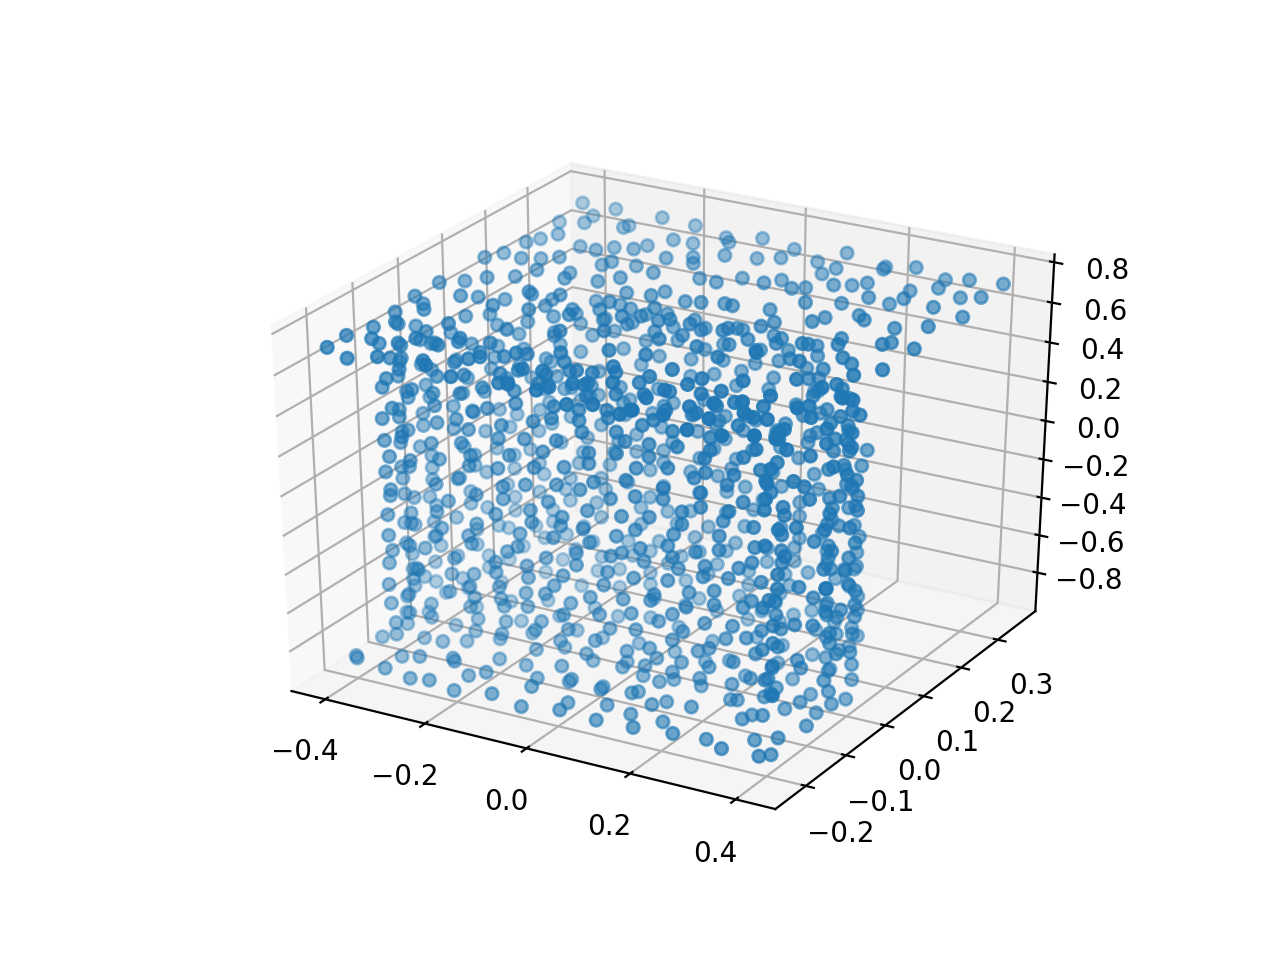

In [36]:
#Simple visualization of the classes

#For some weird reason Visdom does *not* like to be executed in the same cell as a tf.Graph() - sometimes. 
import visdom
viz = visdom.Visdom()
viz.scatter(
        X=pc,
        opts=dict(
            title =cat,
            markersize=5
        ),
    )

#Ugly workaround if Visdom fails to render 
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x =pc[:,0]
y =pc[:,1]
z =pc[:,2]
 
ax.scatter(x, y, z, marker='o')
plt.title = cat
plt.show()

# Example of part segmentation from [ShapeNet](https://www.shapenet.org) data 


In this exercise a subset of the 3D-model collection ShapeNet will be used. In this subset parts (i.e., segmentations into wings, body etc for an airplane) are labeled. Each of the classes has a variable amount of subclasses, for example. When the dataset is loaded, the numeric indexes of 

In [26]:
#Parameters common for training and test
import part_dataset_all_normal
SEG_BATCH_SIZE = 32 
SEG_NUM_POINT = 2048
SEG_LOG_DIR = os.path.join(ROOT_DIR,'part_seg/log/')
SEG_CKPT_NAME = 'model.ckpt' #Change to avoid overwriting if training 
SEG_MODEL_PATH = os.path.join(SEG_LOG_DIR,SEG_CKPT_NAME) 
SEG_MODELNAME = 'pointnet2_part_seg'
SEG_MODEL = importlib.import_module(SEG_MODELNAME) # import network module - look in models folder for others
SEG_VOTE_NUM = 12
SEG_EPOCH_CNT = 0
SEG_MODEL_FILE = os.path.join(ROOT_DIR, 'models', SEG_MODELNAME+'.py')
if not os.path.exists(SEG_LOG_DIR): os.mkdir(SEG_LOG_DIR)
os.system('cp %s %s' % (SEG_MODEL_FILE, SEG_LOG_DIR)) # bkp of model def
os.system('cp train.py %s' % (SEG_LOG_DIR)) # bkp of train procedure
SEG_NUM_CLASSES = 50

# Shapenet official train/test split
SEG_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'shapenetcore_partanno_segmentation_benchmark_v0_normal')
SEG_TEST_DATASET = part_dataset_all_normal.PartNormalDataset(root=SEG_DATA_PATH, npoints=SEG_NUM_POINT, classification=False, split='test')
SEG_TRAIN_DATASET = part_dataset_all_normal.PartNormalDataset(root=SEG_DATA_PATH, npoints=SEG_NUM_POINT, classification=False, split='trainval')



('Airplane', [0, 1, 2, 3])
('Bag', [4, 5])
('Cap', [6, 7])
('Car', [8, 9, 10, 11])
('Chair', [12, 13, 14, 15])
('Earphone', [16, 17, 18])
('Guitar', [19, 20, 21])
('Knife', [22, 23])
('Lamp', [24, 25, 26, 27])
('Laptop', [28, 29])
('Motorbike', [30, 31, 32, 33, 34, 35])
('Mug', [36, 37])
('Pistol', [38, 39, 40])
('Rocket', [41, 42, 43])
('Skateboard', [44, 45, 46])
('Table', [47, 48, 49])
('Airplane', [0, 1, 2, 3])
('Bag', [4, 5])
('Cap', [6, 7])
('Car', [8, 9, 10, 11])
('Chair', [12, 13, 14, 15])
('Earphone', [16, 17, 18])
('Guitar', [19, 20, 21])
('Knife', [22, 23])
('Lamp', [24, 25, 26, 27])
('Laptop', [28, 29])
('Motorbike', [30, 31, 32, 33, 34, 35])
('Mug', [36, 37])
('Pistol', [38, 39, 40])
('Rocket', [41, 42, 43])
('Skateboard', [44, 45, 46])
('Table', [47, 48, 49])


### Familiarize yourself with the data
Use something similar to the code below to visualize examples of the different classes in the dataset, just as you did with the classification dataset.


<IPython.core.display.Javascript object>


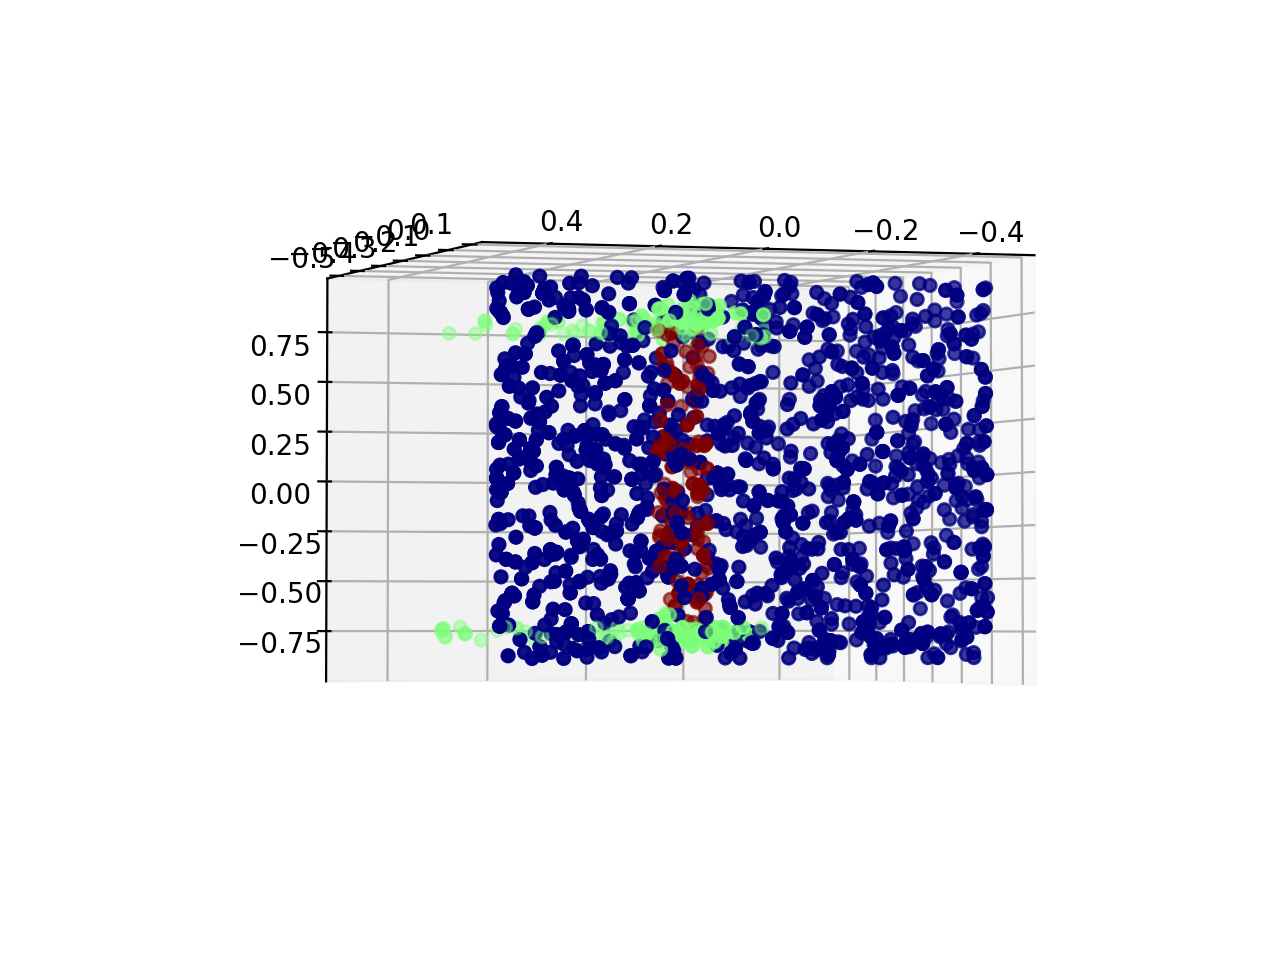

In [35]:
def get_sample(dataset,idx): 
    ps,normal,seg = dataset[idx]
    #print(seg)
    seg_label_to_cat = {} # {0:Airplane, 1:Airplane, ...49:Table} See the dataset method for table that we need a backwards lookup in 
    for cat in list(dataset.seg_classes.keys()):
        for label in dataset.seg_classes[cat]:
            seg_label_to_cat[label] = cat
    category = seg_label_to_cat[mode(seg)]
    seg = seg - seg.min() #Annotations within classes are sequentially numbered
    noLabs = seg.max()+1 
    
    return ps,seg,noLabs,category

ps, seg, noLabs, cat = get_sample(SEG_TRAIN_DATASET,500)

#You can try the Visdom route or just jump to "ugly workaround" 
# viz=Visdom()
#points, seg, noLabs, cat = get_sample(SEG_TRAIN_DATASET,500)
#viz.scatter(
#        X=points,
#        Y=seg+1,
#        opts=dict(
#            title = "Groundtruth "+cat,
#            markersize=5,
#            markercolor=np.floor(np.random.random((noLabs, 3)) * 255)
#        ),
#    )

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cm = plt.get_cmap("jet")
c = seg.squeeze()
x =ps[:,0]
y =ps[:,1]
z =ps[:,2]
ax.scatter(x, y, z, c=c,cmap=cm)

plt.show()

### Batch segmenter
There are basically two approaches for handling the labeling process. Either learn to label into all 50 subclasses, or encode the class of an object into an one-hot vector. Performance over the entire test dataset can be obtained by running the scripts below. Try to get a feel for how the different approaches work. Does the one-hot approach improve segmentation? Model files can be found in the subpath of ROOT_DIR 'models', and checkpoints from training can be found named 'model.ckpt' and 'model_onehot.ckpt' respectively.

In [29]:
def log_string(out_str):
    print(out_str)

def evaluate():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl = SEG_MODEL.placeholder_inputs(SEG_BATCH_SIZE, SEG_NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=()) 
            print("--- Get model and loss")
            pred, end_points = SEG_MODEL.get_model(pointclouds_pl, is_training_pl)
            loss = SEG_MODEL.get_loss(pred, labels_pl)
            saver = tf.train.Saver()
        
        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)
        # Restore variables from disk.
        saver.restore(sess, SEG_MODEL_PATH)
        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss}

        eval_one_epoch(sess, ops)

def get_batch(dataset, idxs, start_idx, end_idx):
  
    bsize = end_idx-start_idx
    batch_data = np.zeros((bsize, SEG_NUM_POINT, 6))
    batch_label = np.zeros((bsize, SEG_NUM_POINT), dtype=np.int32)
    for i in range(bsize):
        ps,normal,seg = dataset[idxs[i+start_idx]]
        batch_data[i,:,0:3] = ps
        batch_data[i,:,3:6] = normal
        batch_label[i,:] = seg
    return batch_data, batch_label

def eval_one_epoch(sess, ops):
    """ ops: dict mapping from string to tf ops """
    is_training = False
    test_idxs = np.arange(0, len(SEG_TEST_DATASET))
    # Test on all data: last batch might be smaller than BATCH_SIZE
    num_batches = (len(SEG_TEST_DATASET)+SEG_BATCH_SIZE-1)/SEG_BATCH_SIZE

    total_correct = 0
    total_seen = 0
    loss_sum = 0
    total_seen_class = [0 for _ in range(SEG_NUM_CLASSES)]
    total_correct_class = [0 for _ in range(SEG_NUM_CLASSES)]

    seg_classes = SEG_TEST_DATASET.seg_classes
    shape_ious = {cat:[] for cat in list(seg_classes.keys())}
    seg_label_to_cat = {} # {0:Airplane, 1:Airplane, ...49:Table}
    for cat in list(seg_classes.keys()):
        for label in seg_classes[cat]:
            seg_label_to_cat[label] = cat

    log_string(str(datetime.now()))
    log_string('---- EPOCH %03d EVALUATION ----'%(SEG_EPOCH_CNT))
    
    batch_data = np.zeros((SEG_BATCH_SIZE, SEG_NUM_POINT, 6))
    batch_label = np.zeros((SEG_BATCH_SIZE, SEG_NUM_POINT)).astype(np.int32)
    for batch_idx in range(int(num_batches)):
        if batch_idx %20==0:
            log_string('%03d/%03d'%(batch_idx, num_batches))
        start_idx = batch_idx * SEG_BATCH_SIZE
        end_idx = min(len(SEG_TEST_DATASET), (batch_idx+1) * SEG_BATCH_SIZE)
        cur_batch_size = end_idx-start_idx
        cur_batch_data, cur_batch_label = get_batch(SEG_TEST_DATASET, test_idxs, start_idx, end_idx)
        if cur_batch_size == SEG_BATCH_SIZE:
            batch_data = cur_batch_data
            batch_label = cur_batch_label
        else:
            batch_data[0:cur_batch_size] = cur_batch_data
            batch_label[0:cur_batch_size] = cur_batch_label

        # ---------------------------------------------------------------------
        loss_val = 0
        pred_val = np.zeros((SEG_BATCH_SIZE, SEG_NUM_POINT, SEG_NUM_CLASSES))
        for _ in range(SEG_VOTE_NUM):
            feed_dict = {ops['pointclouds_pl']: batch_data,
                         ops['labels_pl']: batch_label,
                         ops['is_training_pl']: is_training}
            temp_loss_val, temp_pred_val = sess.run([ops['loss'], ops['pred']], feed_dict=feed_dict)
            loss_val += temp_loss_val
            pred_val += temp_pred_val
        loss_val /= float(SEG_VOTE_NUM)
        # ---------------------------------------------------------------------
    
        # Select valid data
        cur_pred_val = pred_val[0:cur_batch_size]
        # Constrain pred to the groundtruth classes (selected by seg_classes[cat])
        cur_pred_val_logits = cur_pred_val
        cur_pred_val = np.zeros((cur_batch_size, SEG_NUM_POINT)).astype(np.int32)
        for i in range(cur_batch_size):
            cat = seg_label_to_cat[cur_batch_label[i,0]]
            logits = cur_pred_val_logits[i,:,:]
            cur_pred_val[i,:] = np.argmax(logits[:,seg_classes[cat]], 1) + seg_classes[cat][0]
        correct = np.sum(cur_pred_val == cur_batch_label)
        total_correct += correct
        total_seen += (cur_batch_size*SEG_NUM_POINT)
        if cur_batch_size==SEG_BATCH_SIZE:
            loss_sum += loss_val
        for l in range(SEG_NUM_CLASSES):
            total_seen_class[l] += np.sum(cur_batch_label==l)
            total_correct_class[l] += (np.sum((cur_pred_val==l) & (cur_batch_label==l)))

        for i in range(cur_batch_size):
            segp = cur_pred_val[i,:]
            segl = cur_batch_label[i,:] 
            cat = seg_label_to_cat[segl[0]]
            part_ious = [0.0 for _ in range(len(seg_classes[cat]))]
            for l in seg_classes[cat]:
                if (np.sum(segl==l) == 0) and (np.sum(segp==l) == 0): # part is not present, no prediction as well
                    part_ious[l-seg_classes[cat][0]] = 1.0
                else:
                    part_ious[l-seg_classes[cat][0]] = np.sum((segl==l) & (segp==l)) / float(np.sum((segl==l) | (segp==l)))
            shape_ious[cat].append(np.mean(part_ious))

    all_shape_ious = []
    for cat in list(shape_ious.keys()):
        for iou in shape_ious[cat]:
            all_shape_ious.append(iou)
        shape_ious[cat] = np.mean(shape_ious[cat])
    print(len(all_shape_ious))
    mean_shape_ious = np.mean(list(shape_ious.values()))
    log_string('eval mean loss: %f' % (loss_sum / float(len(SEG_TEST_DATASET)/SEG_BATCH_SIZE)))
    log_string('eval accuracy: %f'% (total_correct / float(total_seen)))
    log_string('eval avg class acc: %f' % (np.mean(np.array(total_correct_class)/np.array(total_seen_class,dtype=np.float))))
    for cat in sorted(shape_ious.keys()):
        log_string('eval mIoU of %s:\t %f'%(cat, shape_ious[cat]))
    log_string('eval mean mIoU: %f' % (mean_shape_ious))
    log_string('eval mean mIoU (all shapes): %f' % (np.mean(all_shape_ious)))
         


In [30]:
with tf.Graph().as_default():
    evaluate()

--- Get model and loss
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Restoring parameters from /home/ec2-user/Labs/Lab4/pointnet2/part_seg/log/model.ckpt
2018-02-23 09:16:00.402440
---- EPOCH 000 EVALUATION ----
000/090
020/090
040/090
060/090
080/090
2874
eval mean loss: 0.263465
eval accuracy: 0.928817
eval avg class acc: 0.802016
eval mIoU of Airplane:	 0.794566
eval mIoU of Bag:	 0.559305
eval mIoU of Cap:	 0.862793
eval mIoU of Car:	 0.723383
eval mIoU of Chair:	 0.890785
eval mIoU of Earphone:	 0.700806
eval mIoU of Guitar:	 0.887979
eval mIoU of Knife:	 0.848548
eval mIoU of Lamp:	 0.827169
eval mIoU of Laptop:	 0.947313
eval mIoU of Motorbike:	 0.532296
eval mIoU of Mug:	 0.895113
eval mIoU of Pistol:	 0.723287
eval mIoU of Rocket:	 0.524477
eval mIoU of Skateboard:	 0.730118
eval mIoU of Table:	 0.812371
eval mean mIoU: 0.766269
eval mean mIoU (all sha

### Visualize a segmentation of a pointcloud
Note: The pointclouds for the segmentation are normalized, so shapes may be a bit deformed. In principle the pointcloud can be of any size for the segmentation and thus this approach could be used for large scale semantic segmentation with appropriate training data and subsetting of the cloud, but this notebook will only look at single object segmentation. 


In [50]:
def get_sample(dataset,idx): 
    ps,normal,seg = dataset[idx]
    #print(seg)
    seg_label_to_cat = {} # {0:Airplane, 1:Airplane, ...49:Table} See the dataset method for table that we need a backwards lookup in 
    for cat in list(dataset.seg_classes.keys()):
        for label in dataset.seg_classes[cat]:
            seg_label_to_cat[label] = cat
    category = seg_label_to_cat[mode(seg)]
    seg = seg - seg.min() #Annotations within classes are sequentially numbered
    noLabs = seg.max()+1 
    data = np.zeros((1, SEG_NUM_POINT, 6))
    data[0,:,0:3]=ps
    data[0,:,3:6]=normal
    return data,seg,noLabs,category

def segment_sample(pc):
    with tf.device('/gpu:'+str(GPU_INDEX)):
        is_training = False
        pointclouds_pl, labels_pl = SEG_MODEL.placeholder_inputs(1, SEG_NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=()) 
        pred, end_points = SEG_MODEL.get_model(pointclouds_pl, is_training_pl)
        loss = SEG_MODEL.get_loss(pred, labels_pl)
        saver = tf.train.Saver()
        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)
        # Restore variables from disk.
        saver.restore(sess, SEG_MODEL_PATH)
        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss}
        # ---------------------------------------------------------------------
        loss_val = 0
        pred_val = np.zeros((1, SEG_NUM_POINT, SEG_NUM_CLASSES))
        labels= np.zeros((1,SEG_NUM_POINT), dtype=np.int32)
        for _ in range(SEG_VOTE_NUM):
            feed_dict = {ops['pointclouds_pl']: pc,
                         ops['labels_pl']: labels,
                         ops['is_training_pl']: is_training}
            temp_loss_val, temp_pred_val = sess.run([ops['loss'], ops['pred']], feed_dict=feed_dict)
            loss_val += temp_loss_val
            pred_val += temp_pred_val
        loss_val /= float(SEG_VOTE_NUM)
        # ---------------------------------------------------------------------
        seg = np.argmax(np.argmax(pred_val, 1))
        return seg

ps, seg, noLabs, cat = get_sample(SEG_TRAIN_DATASET,500)
with tf.Graph().as_default():
    pred = segment_sample(ps)



#You can try the Visdom route or just jump to "ugly workaround" 
# viz=Visdom()
#points, seg, noLabs, cat = get_sample(SEG_TRAIN_DATASET,500)
#viz.scatter(
#        X=points,
#        Y=seg+1,
#        opts=dict(
#            title = "Groundtruth "+cat,
#            markersize=5,
#            markercolor=np.floor(np.random.random((noLabs, 3)) * 255)
#        ),
#    )

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cm = plt.get_cmap("jet")
c = pred.squeeze()
x =ps[:,0]
y =ps[:,1]
z =ps[:,2]
ax.scatter(x, y, z, c=c,cmap=cm)

plt.show()

INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Restoring parameters from /home/ec2-user/Labs/Lab4/pointnet2/part_seg/log/model.ckpt


ResourceExhaustedError: OOM when allocating tensor with shape[1,512,64,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: layer1/conv2/bn/batchnorm/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](layer1/conv2/BiasAdd, layer1/conv2/bn/batchnorm/mul)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: layer3/Squeeze/_269 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_722_layer3/Squeeze", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'layer1/conv2/bn/batchnorm/mul_1', defined at:
  File "/usr/lib64/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib64/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.4/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3.4/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib/python3.4/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib64/python3.4/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib64/python3.4/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib64/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib64/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib64/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib64/python3.4/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/lib/python3.4/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/lib/python3.4/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-0d2f0fd7ae31>", line 54, in <module>
    pred = segment_sample(ps)
  File "<ipython-input-50-0d2f0fd7ae31>", line 21, in segment_sample
    pred, end_points = SEG_MODEL.get_model(pointclouds_pl, is_training_pl)
  File "/home/ec2-user/Labs/Lab4/pointnet2/models/pointnet2_part_seg.py", line 26, in get_model
    l1_xyz, l1_points, l1_indices = pointnet_sa_module(l0_xyz, l0_points, npoint=512, radius=0.2, nsample=64, mlp=[64,64,128], mlp2=None, group_all=False, is_training=is_training, bn_decay=bn_decay, scope='layer1')
  File "/home/ec2-user/Labs/Lab4/pointnet2/utils/pointnet_util.py", line 118, in pointnet_sa_module
    scope='conv%d'%(i), bn_decay=bn_decay)
  File "/home/ec2-user/Labs/Lab4/pointnet2/utils/tf_util.py", line 164, in conv2d
    bn_decay=bn_decay, scope='bn')
  File "/home/ec2-user/Labs/Lab4/pointnet2/utils/tf_util.py", line 543, in batch_norm_for_conv2d
    return batch_norm_template(inputs, is_training, scope, [0,1,2], bn_decay)
  File "/home/ec2-user/Labs/Lab4/pointnet2/utils/tf_util.py", line 499, in batch_norm_template
    normed = tf.nn.batch_normalization(inputs, mean, var, beta, gamma, 1e-3)
  File "/usr/lib/python3.4/dist-packages/tensorflow/python/ops/nn_impl.py", line 809, in batch_normalization
    return x * inv + (offset - mean * inv
  File "/usr/lib/python3.4/dist-packages/tensorflow/python/ops/math_ops.py", line 907, in binary_op_wrapper
    return func(x, y, name=name)
  File "/usr/lib/python3.4/dist-packages/tensorflow/python/ops/math_ops.py", line 1131, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/usr/lib/python3.4/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 2798, in _mul
    "Mul", x=x, y=y, name=name)
  File "/usr/lib/python3.4/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/usr/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,512,64,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: layer1/conv2/bn/batchnorm/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](layer1/conv2/BiasAdd, layer1/conv2/bn/batchnorm/mul)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: layer3/Squeeze/_269 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_722_layer3/Squeeze", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



# Breaking stuff
The true test of a DNN is when applied to unexpected or real data, and that is usually when the fun begins.
![XKCD 1838](https://imgs.xkcd.com/comics/machine_learning_2x.png)

## Out-of-sample experiment
Since ShapeNet and ModelNet have some overlapping classes it is interesting to evaluate how well the different algorithms work on realistic but guaranteed "not seen" data. Try to evaluate results going both ways if you have time.

In this setting the code could be set up as follows:

In [ ]:
#Copy code for getting single example from the dataset
#Subsample if necessary - can be done with a simple numpy shuffle and picking the first N points
# ... Feed it to your network
#Visualize output

## Images from an Intel RealSense 3D-camera 
For those that do not have a bunch of 3d data hanging around, we have some available that you can grab here from the notebook. Just run the appropriate python code below and data should magically appear as pointclouds with labels. YMMV when it comes to get any sensible classification and/or segmentation results out of it - but that is the challenge! 

Remember to feed the network the number of points it expects. 

## Brief overview of network training
The models are slightly too complex to train in reasonable time on a live exercise and relies on some custom TensorFlow operations implemented in C++ (compiled from our [fork](https://github.com/asbe/pointnet2)), so we will not be live training the networks, but we leave training code here for you to enjoy. 

Below is also scripts for training new models for experimenting with settings and models. Rewrite these to [continue from checkpoints](https://www.tensorflow.org/versions/master/programmers_guide/saved_model) files provided to avoid starting from scratch.   




### Training of classification 

In [32]:
CLS_EPOCH_CNT = 0
CLS_MAX_EPOCH = 251
CLS_BASE_LEARNING_RATE = 0.001
CLS_MOMENTUM = 0.9
CLS_OPTIMIZER = 'adam'
CLS_DECAY_STEP = 200000
CLS_DECAY_RATE = 0.7

In [33]:
#MODEL = importlib.import_module(FLAGS.model) # import network module
CLS_MODEL_FILE = os.path.join(ROOT_DIR, 'models', CLS_MODELNAME+'.py')
#LOG_DIR = os.path.join(ROOT_DIR,'classification/log/')
if not os.path.exists(CLS_LOG_DIR): os.mkdir(CLS_LOG_DIR)
os.system('cp %s %s' % (CLS_MODEL_FILE, CLS_LOG_DIR)) # bkp of model def
os.system('cp train.py %s' % (CLS_LOG_DIR)) # bkp of train procedure
CLS_LOG_FOUT = open(os.path.join(CLS_LOG_DIR, 'log_train.txt'), 'w')
#LOG_FOUT.write(str(FLAGS)+'\n')

CLS_BN_INIT_DECAY = 0.5
CLS_BN_DECAY_DECAY_RATE = 0.5
CLS_BN_DECAY_DECAY_STEP = float(CLS_DECAY_STEP)
CLS_BN_DECAY_CLIP = 0.99

# Shapenet official train/test split
#DATA_PATH = os.path.join(ROOT_DIR, 'data/modelnet40_normal_resampled')
#TRAIN_DATASET = modelnet_dataset.ModelNetDataset(root=DATA_PATH, npoints=NUM_POINT, split='train', normal_channel=FLAGS.normal)
#TEST_DATASET = modelnet_dataset.ModelNetDataset(root=DATA_PATH, npoints=NUM_POINT, split='test', normal_channel=FLAGS.normal)

def log_string(out_str):
    CLS_LOG_FOUT.write(out_str+'\n')
    CLS_LOG_FOUT.flush()
    print(out_str)

def get_learning_rate(batch):
    learning_rate = tf.train.exponential_decay(
                        CLS_BASE_LEARNING_RATE,  # Base learning rate.
                        batch * CLS_BATCH_SIZE,  # Current index into the dataset.
                        CLS_DECAY_STEP,          # Decay step.
                        CLS_DECAY_RATE,          # Decay rate.
                        staircase=True)
    learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
    return learning_rate        

def get_bn_decay(batch):
    bn_momentum = tf.train.exponential_decay(
                      CLS_BN_INIT_DECAY,
                      batch*CLS_BATCH_SIZE,
                      CLS_BN_DECAY_DECAY_STEP,
                      CLS_BN_DECAY_DECAY_RATE,
                      staircase=True)
    bn_decay = tf.minimum(CLS_BN_DECAY_CLIP, 1 - bn_momentum)
    return bn_decay

def train(): 
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl = CLS_MODEL.placeholder_inputs(CLS_BATCH_SIZE, CLS_NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)

            # Get model and loss 
            pred, end_points = CLS_MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = CLS_MODEL.get_loss(pred, labels_pl, end_points)
            tf.summary.scalar('loss', loss)

            correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(CLS_BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            print("--- Get training operator")
            # Get training operator
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if CLS_OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=CLS_MOMENTUM)
            elif CLS_OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)
            
            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()
        
        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        # Add summary writers
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(os.path.join(CLS_LOG_DIR, 'train'), sess.graph)
        test_writer = tf.summary.FileWriter(os.path.join(CLS_LOG_DIR, 'test'), sess.graph)

        # Init variables
        init = tf.global_variables_initializer()
        sess.run(init)

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch,
               'end_points': end_points}

        best_acc = -1
        f = FloatProgress(min=0, max=int(CLS_MAX_EPOCH))
        display(f)
        for epoch in range(CLS_MAX_EPOCH):
            #log_string('**** EPOCH %03d ****' % (epoch))
            #sys.stdout.flush()    
            f.value +=1
            f.description = "Epoch {}/{}".format(epoch, CLS_MAX_EPOCH)
            train_one_epoch(sess, ops, train_writer)
            eval_one_epoch(sess, ops, test_writer)

            # Save the variables to disk.
            if epoch % 10 == 0:
                save_path = saver.save(sess, os.path.join(CLS_LOG_DIR,CLS_CKPT_NAME))
                log_string("Model saved in file: %s" % save_path)

def get_batch(dataset, idxs, start_idx, end_idx):
    ''' if bsize < BATCH_SIZE, use zero to pad '''
    bsize = end_idx-start_idx
    batch_data = np.zeros((CLS_BATCH_SIZE, CLS_NUM_POINT, dataset.num_channel()))
    batch_label = np.zeros((CLS_BATCH_SIZE), dtype=np.int32)
    for i in range(bsize):
        ps,cls = dataset[idxs[i+start_idx]]
        batch_data[i] = ps
        batch_label[i] = cls
    return batch_data, batch_label

def augment_batch_data(batch_data):
    if CLS_USENORMAL:
        rotated_data = provider.rotate_point_cloud_with_normal(batch_data)
        rotated_data = provider.rotate_perturbation_point_cloud_with_normal(rotated_data)
    else:
        rotated_data = provider.rotate_point_cloud(batch_data)
        rotated_data = provider.rotate_perturbation_point_cloud(rotated_data)

    jittered_data = provider.random_scale_point_cloud(rotated_data[:,:,0:3])
    jittered_data = provider.shift_point_cloud(jittered_data)
    jittered_data = provider.jitter_point_cloud(jittered_data)
    rotated_data[:,:,0:3] = jittered_data
    return rotated_data

def train_one_epoch(sess, ops, train_writer):
    """ ops: dict mapping from string to tf ops """
    is_training = True
    
    # Shuffle train samples
    train_idxs = np.arange(0, len(CLS_TRAIN_DATASET))
    np.random.shuffle(train_idxs)
    num_batches = len(CLS_TRAIN_DATASET)/CLS_BATCH_SIZE
    
    log_string(str(datetime.now()))

    total_correct = 0
    total_seen = 0
    loss_sum = 0
    for batch_idx in range(int(num_batches)):
        start_idx = batch_idx * CLS_BATCH_SIZE
        end_idx = (batch_idx+1) * CLS_BATCH_SIZE
        batch_data, batch_label = get_batch(CLS_TRAIN_DATASET, train_idxs, start_idx, end_idx)
        aug_data = augment_batch_data(batch_data)
        #aug_data = provider.random_point_dropout(aug_data)
        feed_dict = {ops['pointclouds_pl']: aug_data,
                     ops['labels_pl']: batch_label,
                     ops['is_training_pl']: is_training,}
        summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
            ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)
        train_writer.add_summary(summary, step)
        pred_val = np.argmax(pred_val, 1)
        correct = np.sum(pred_val == batch_label)
        total_correct += correct
        total_seen += CLS_BATCH_SIZE
        loss_sum += loss_val

        if (batch_idx+1)%50 == 0:
            log_string(' -- %03d / %03d --' % (batch_idx+1, num_batches))
            log_string('mean loss: %f' % (loss_sum / 50))
            log_string('accuracy: %f' % (total_correct / float(total_seen)))
            total_correct = 0
            total_seen = 0
            loss_sum = 0
        

        
def eval_one_epoch(sess, ops, test_writer):
    """ ops: dict mapping from string to tf ops """
    global CLS_EPOCH_CNT
    is_training = False
    test_idxs = np.arange(0, len(CLS_TEST_DATASET))
    num_batches = (len(CLS_TEST_DATASET)+CLS_BATCH_SIZE-1)/CLS_BATCH_SIZE

    total_correct = 0
    total_seen = 0
    loss_sum = 0
    shape_ious = []
    total_seen_class = [0 for _ in range(CLS_NUM_CLASSES)]
    total_correct_class = [0 for _ in range(CLS_NUM_CLASSES)]
    
    log_string(str(datetime.now()))
    log_string('---- EPOCH %03d EVALUATION ----'%(CLS_EPOCH_CNT))
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * CLS_BATCH_SIZE
        end_idx = min((batch_idx+1) * CLS_BATCH_SIZE, len(CLS_TEST_DATASET))
        bsize = end_idx - start_idx
        batch_data, batch_label = get_batch(CLS_TEST_DATASET, test_idxs, start_idx, end_idx)

        feed_dict = {ops['pointclouds_pl']: batch_data,
                     ops['labels_pl']: batch_label,
                     ops['is_training_pl']: is_training}
        summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
            ops['loss'], ops['pred']], feed_dict=feed_dict)
        test_writer.add_summary(summary, step)
        pred_val = np.argmax(pred_val, 1)
        correct = np.sum(pred_val[0:bsize] == batch_label[0:bsize])
        total_correct += correct
        total_seen += bsize
        loss_sum += (loss_val*float(bsize/CLS_BATCH_SIZE))
        for i in range(start_idx, end_idx):
            l = batch_label[i-start_idx]
            total_seen_class[l] += 1
            total_correct_class[l] += (pred_val[i-start_idx] == l)
    
    log_string('eval mean loss: %f' % (loss_sum / float(num_batches)))
    log_string('eval accuracy: %f'% (total_correct / float(total_seen)))
    log_string('eval avg class acc: %f' % (np.mean(np.array(total_correct_class)/np.array(total_seen_class,dtype=np.float))))
    EPOCH_CNT += 1
    return total_correct/float(total_seen)



In [35]:
with tf.Graph().as_default():
    train()

--- Get training operator


FloatProgress(value=0.0, max=251.0)

2018-02-22 23:24:49.966749


KeyboardInterrupt: 

### Training of part segmentation

In [39]:
import tf_util

SEG_MAX_EPOCH = 201
SEG_MOMENTUM = 0.9
SEG_BASE_LEARNING_RATE = 0.001
SEG_OPTIMIZER = 'adam'
SEG_DECAY_STEP = 200000
SEG_DECAY_RATE = 0.7

SEG_BN_INIT_DECAY = 0.5
SEG_BN_DECAY_DECAY_RATE = 0.5
SEG_BN_DECAY_DECAY_STEP = float(SEG_DECAY_STEP)
SEG_BN_DECAY_CLIP = 0.99

def log_string(out_str):
    print(out_str)

def get_learning_rate(batch):
    learning_rate = tf.train.exponential_decay(
                        SEG_BASE_LEARNING_RATE,  # Base learning rate.
                        batch * SEG_BATCH_SIZE,  # Current index into the dataset.
                        SEG_DECAY_STEP,          # Decay step.
                        SEG_DECAY_RATE,          # Decay rate.
                        staircase=True)
    learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
    return learning_rate        

def get_bn_decay(batch):
    bn_momentum = tf.train.exponential_decay(
                      SEG_BN_INIT_DECAY,
                      batch*SEG_BATCH_SIZE,
                      SEG_BN_DECAY_DECAY_STEP,
                      SEG_BN_DECAY_DECAY_RATE,
                      staircase=True)
    bn_decay = tf.minimum(SEG_BN_DECAY_CLIP, 1 - bn_momentum)
    return bn_decay

def train():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl = SEG_MODEL.placeholder_inputs(SEG_BATCH_SIZE, SEG_NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)

            print("--- Get model and loss")
            # Get model and loss 
            pred, end_points = SEG_MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = SEG_MODEL.get_loss(pred, labels_pl)
            tf.summary.scalar('loss', loss)

            correct = tf.equal(tf.argmax(pred, 2), tf.to_int64(labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(SEG_BATCH_SIZE*SEG_NUM_POINT)
            tf.summary.scalar('accuracy', accuracy)

            print("--- Get training operator")
            # Get training operator
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if SEG_OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=SEG_MOMENTUM)
            elif SEG_OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)
            
            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()
        
        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        # Add summary writers
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(os.path.join(SEG_LOG_DIR, 'train'), sess.graph)
        test_writer = tf.summary.FileWriter(os.path.join(SEG_LOG_DIR, 'test'), sess.graph)

        # Init variables
        init = tf.global_variables_initializer()
        sess.run(init)

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch,
               'end_points': end_points}

        best_acc = -1
        for epoch in range(SEG_MAX_EPOCH):
            log_string('**** EPOCH %03d ****' % (epoch))
            sys.stdout.flush()
             
            train_one_epoch(sess, ops, train_writer)
            eval_one_epoch(sess, ops, test_writer)

            # Save the variables to disk.
            if epoch % 10 == 0:
                save_path = saver.save(sess, os.path.join(SEG_LOG_DIR, SEG_CKPT_NAME))
                log_string("Model saved in file: %s" % save_path)

def get_batch(dataset, idxs, start_idx, end_idx):
    bsize = end_idx-start_idx
    batch_data = np.zeros((bsize, SEG_NUM_POINT, 6))
    batch_label = np.zeros((bsize, SEG_NUM_POINT), dtype=np.int32)
    for i in range(bsize):
        ps,normal,seg = dataset[idxs[i+start_idx]]
        batch_data[i,:,0:3] = ps
        batch_data[i,:,3:6] = normal
        batch_label[i,:] = seg
    return batch_data, batch_label

def train_one_epoch(sess, ops, train_writer):
    """ ops: dict mapping from string to tf ops """
    is_training = True
    
    # Shuffle train samples
    train_idxs = np.arange(0, len(SEG_TRAIN_DATASET))
    np.random.shuffle(train_idxs)
    num_batches = len(SEG_TRAIN_DATASET)/SEG_BATCH_SIZE
    
    log_string(str(datetime.now()))

    total_correct = 0
    total_seen = 0
    loss_sum = 0
    for batch_idx in range(int(num_batches)):
        start_idx = batch_idx * SEG_BATCH_SIZE
        end_idx = (batch_idx+1) * SEG_BATCH_SIZE
        batch_data, batch_label = get_batch(SEG_TRAIN_DATASET, train_idxs, start_idx, end_idx)
        # Augment batched point clouds by rotation and jittering
        #aug_data = batch_data
        #aug_data = provider.random_scale_point_cloud(batch_data)
        batch_data[:,:,0:3] = provider.jitter_point_cloud(batch_data[:,:,0:3])
        feed_dict = {ops['pointclouds_pl']: batch_data,
                     ops['labels_pl']: batch_label,
                     ops['is_training_pl']: is_training,}
        summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
            ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)
        train_writer.add_summary(summary, step)
        pred_val = np.argmax(pred_val, 2)
        correct = np.sum(pred_val == batch_label)
        total_correct += correct
        total_seen += (SEG_BATCH_SIZE*SEG_NUM_POINT)
        loss_sum += loss_val

        if (batch_idx+1)%10 == 0:
            log_string(' -- %03d / %03d --' % (batch_idx+1, num_batches))
            log_string('mean loss: %f' % (loss_sum / 10))
            log_string('accuracy: %f' % (total_correct / float(total_seen)))
            total_correct = 0
            total_seen = 0
            loss_sum = 0
        

        
def eval_one_epoch(sess, ops, test_writer):
    """ ops: dict mapping from string to tf ops """
    global SEG_EPOCH_CNT
    is_training = False
    test_idxs = np.arange(0, len(SEG_TEST_DATASET))
    # Test on all data: last batch might be smaller than BATCH_SIZE
    num_batches = (len(SEG_TEST_DATASET)+SEG_BATCH_SIZE-1)/SEG_BATCH_SIZE

    total_correct = 0
    total_seen = 0
    loss_sum = 0
    total_seen_class = [0 for _ in range(SEG_NUM_CLASSES)]
    total_correct_class = [0 for _ in range(SEG_NUM_CLASSES)]

    seg_classes = SEG_TEST_DATASET.seg_classes
    shape_ious = {cat:[] for cat in list(seg_classes.keys())}
    seg_label_to_cat = {} # {0:Airplane, 1:Airplane, ...49:Table}
    for cat in list(seg_classes.keys()):
        for label in seg_classes[cat]:
            seg_label_to_cat[label] = cat

    log_string(str(datetime.now()))
    log_string('---- EPOCH %03d EVALUATION ----'%(SEG_EPOCH_CNT))
    
    batch_data = np.zeros((SEG_BATCH_SIZE, SEG_NUM_POINT, 3))
    batch_label = np.zeros((SEG_BATCH_SIZE, SEG_NUM_POINT)).astype(np.int32)
    for batch_idx in range(int(num_batches)):
        if batch_idx %20==0:
            log_string('%03d/%03d'%(batch_idx, num_batches))
        start_idx = batch_idx * SEG_BATCH_SIZE
        end_idx = min(len(SEG_TEST_DATASET), (batch_idx+1) * SEG_BATCH_SIZE)
        cur_batch_size = end_idx-start_idx
        cur_batch_data, cur_batch_label = get_batch(SEG_TEST_DATASET, test_idxs, start_idx, end_idx)
        if cur_batch_size == SEG_BATCH_SIZE:
            batch_data = cur_batch_data
            batch_label = cur_batch_label
        else:
            batch_data[0:cur_batch_size] = cur_batch_data
            batch_label[0:cur_batch_size] = cur_batch_label

        # ---------------------------------------------------------------------
        feed_dict = {ops['pointclouds_pl']: batch_data,
                     ops['labels_pl']: batch_label,
                     ops['is_training_pl']: is_training}
        summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
            ops['loss'], ops['pred']], feed_dict=feed_dict)
        test_writer.add_summary(summary, step)
        # ---------------------------------------------------------------------
    
        # Select valid data
        cur_pred_val = pred_val[0:cur_batch_size]
        # Constrain pred to the groundtruth classes (selected by seg_classes[cat])
        cur_pred_val_logits = cur_pred_val
        cur_pred_val = np.zeros((cur_batch_size, SEG_NUM_POINT)).astype(np.int32)
        for i in range(cur_batch_size):
            cat = seg_label_to_cat[cur_batch_label[i,0]]
            logits = cur_pred_val_logits[i,:,:]
            cur_pred_val[i,:] = np.argmax(logits[:,seg_classes[cat]], 1) + seg_classes[cat][0]
        correct = np.sum(cur_pred_val == cur_batch_label)
        total_correct += correct
        total_seen += (cur_batch_size*SEG_NUM_POINT)
        if cur_batch_size==SEG_BATCH_SIZE:
            loss_sum += loss_val
        for l in range(SEG_NUM_CLASSES):
            total_seen_class[l] += np.sum(cur_batch_label==l)
            total_correct_class[l] += (np.sum((cur_pred_val==l) & (cur_batch_label==l)))

        for i in range(cur_batch_size):
            segp = cur_pred_val[i,:]
            segl = cur_batch_label[i,:] 
            cat = seg_label_to_cat[segl[0]]
            part_ious = [0.0 for _ in range(len(seg_classes[cat]))]
            for l in seg_classes[cat]:
                if (np.sum(segl==l) == 0) and (np.sum(segp==l) == 0): # part is not present, no prediction as well
                    part_ious[l-seg_classes[cat][0]] = 1.0
                else:
                    part_ious[l-seg_classes[cat][0]] = np.sum((segl==l) & (segp==l)) / float(np.sum((segl==l) | (segp==l)))
            shape_ious[cat].append(np.mean(part_ious))

    all_shape_ious = []
    for cat in list(shape_ious.keys()):
        for iou in shape_ious[cat]:
            all_shape_ious.append(iou)
        shape_ious[cat] = np.mean(shape_ious[cat])
    mean_shape_ious = np.mean(list(shape_ious.values()))
    log_string('eval mean loss: %f' % (loss_sum / float(len(SEG_TEST_DATASET)/SEG_BATCH_SIZE)))
    log_string('eval accuracy: %f'% (total_correct / float(total_seen)))
    log_string('eval avg class acc: %f' % (np.mean(np.array(total_correct_class)/np.array(total_seen_class,dtype=np.float))))
    for cat in sorted(shape_ious.keys()):
        log_string('eval mIoU of %s:\t %f'%(cat, shape_ious[cat]))
    log_string('eval mean mIoU: %f' % (mean_shape_ious))
    log_string('eval mean mIoU (all shapes): %f' % (np.mean(all_shape_ious)))
         
    SEG_EPOCH_CNT += 1
    return total_correct/float(total_seen)




In [40]:
 with tf.Graph().as_default():
        train()


--- Get model and loss
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
--- Get training operator
**** EPOCH 000 ****
2018-02-22 23:26:39.812207


KeyboardInterrupt: 